In [ ]:
!nvidia-smi

Mon Nov 29 04:21:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
os.chdir("/content/drive/My Drive/Computer Vision 2021")

!ls
!rm -rf /data
!mkdir /data
!cp train2017_custom2.zip /data
!cp val2017_custom2.zip /data

os.chdir("/data")
!ls

!unzip train2017_custom2.zip > /dev/null
!unzip val2017_custom2.zip > /dev/null

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip
!cp annotations/instances_train2017.json .
!cp annotations/instances_val2017.json .

!rm -rf annotations/
!rm *.zip

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 COCO-val2014-BBox-Results.gsheet
 fcn_test_10.pth
 fcn_test_scratch_10.pth
 fcn_test_scratch_15.pth
 fcn_test_scratch_data_augment_20.pth
 fcn_test_scratch_data_augment_focal_loss_10.pth
 fcn_test_scratch_data_augment_focal_loss_v2_10.pth
 fcn_test_scratch_data_augment_focal_loss_v2_20.pth
 fcn_test_scratch_data_augment_v2_10.pth
 fcn_test_scratch_data_augment_v2_20.pth
 fcn_test_scratch_v2_10.pth
'Progress Report.gdoc'
'Project Proposal (Computer Vision 2021):.gdoc'
 train2017_custom2.zip
 train2017_custom.zip
'Useful Links.gdoc'
 val2017_custom2.zip
 val2017_custom.zip
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
train2017_custom2.zip  val2017_custom2.zip
--2021-11-29 04:21:57--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (ima

In [ ]:
!df -h
import os
os.chdir("/data")
!ls

Filesystem      Size  Used Avail Use% Mounted on
overlay         167G   48G  120G  29% /
tmpfs            64M     0   64M   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  821M  59% /sbin/docker-init
tmpfs           6.4G   40K  6.4G   1% /var/colab
/dev/sda1       174G   55G  119G  32% /opt/bin/.nvidia
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive           167G   54G  114G  32% /content/drive
instances_train2017.json  train2017_custom_2
instances_val2017.json	  val2017_custom_2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

from pycocotools.coco import COCO

from PIL import Image

import numpy as np
import random

import os
import tqdm

import matplotlib
import matplotlib.pyplot as plt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

%matplotlib inline

cuda


In [ ]:
CATEGORIES = [
            "airplane",
            "bicycle",
            "bird",
            "boat",
            "bottle",
            "bus",
            "car",
            "cat",
            "chair",
            "cow",
            "dining table",
            "dog",
            "horse",
            "motorcycle",
            "person",
            "potted plant",
            "sheep",
            "couch",
            "train",
            "tv"
        ]
CATEGORIES = sorted(CATEGORIES)

class CustomDataset(Dataset):

    def __init__(self, image_folder_path,
                       annotations_file,
                       augment=False):
        self.augment = augment
        self.image_folder_path = image_folder_path
        self.coco = COCO(annotations_file)

        self.image_ids = []
        for image_id in self.coco.imgs:
            fname = self.coco.imgs[image_id]["file_name"]
            fpath = os.path.join(image_folder_path, fname)

            if os.path.isfile(fpath):
                self.image_ids.append(image_id)

        categories = self.coco.loadCats(self.coco.getCatIds())

        category_names_to_ids = {}
        for c in categories:
            category_names_to_ids[c["name"]] = c["id"]

        self.category_ids = []
        for c in CATEGORIES:
            self.category_ids.append(category_names_to_ids[c])

        self.category_id_mapping = {}
        self.category_id_mapping[0] = 0
        for i in range(len(CATEGORIES)):
            self.category_id_mapping[category_names_to_ids[CATEGORIES[i]]] = i + 1

        print(category_names_to_ids)
        print(self.category_id_mapping)

        assert len(self.category_ids) == len(CATEGORIES), len(self.category_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        fname = self.coco.imgs[img_id]["file_name"]
        img_path = os.path.join(self.image_folder_path, fname)

        img = Image.open(img_path).convert("RGB")

        anns_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.category_ids, iscrowd=None)
        anns = self.coco.loadAnns(anns_ids)

        W, H = img.size
        mask = np.zeros((H, W))
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann) * self.category_id_mapping[ann["category_id"]])
        
        mask = torch.from_numpy(mask)

        img = TF.to_tensor(img)

        resize = transforms.Resize(size=(256, 256))
        img = resize(img)
        mask = resize(mask.unsqueeze(0)).squeeze()

        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img = normalize(img)

        if self.augment:
          if random.random() > 0.5:
              img = TF.hflip(img)
              mask = TF.hflip(mask)

          if random.random() > 0.5:
              img = TF.vflip(img)
              mask = TF.vflip(mask)

        return img, mask

    def __len__(self):
        return len(self.image_ids)

In [ ]:
train_dataset = CustomDataset(image_folder_path="/data/train2017_custom_2", annotations_file="/data/instances_train2017.json", augment=True)
val_dataset = CustomDataset(image_folder_path="/data/val2017_custom_2", annotations_file="/data/instances_val2017.json")

loading annotations into memory...
Done (t=16.57s)
creating index...
index created!
{'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 70, 'tv': 72, '

In [ ]:
BATCH_SIZE = 16

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=False)
model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

def show_images(img, label, prediction=None):
  if prediction is not None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  else:
    fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.imshow(img.cpu().squeeze().permute(1, 2, 0))
  ax1.set_title("Input image")

  _, W, H = img.size()

  r = Image.fromarray(label.byte().cpu().numpy()).resize((W, H))
  r.putpalette(colors)
  ax2.imshow(r)
  ax2.set_title("Ground truth")

  if prediction is not None:
    r = Image.fromarray(prediction.byte().cpu().numpy()).resize((W, H))
    r.putpalette(colors)
    ax3.imshow(r)
    ax3.set_title("Prediction")
  plt.show()

In [ ]:
# From https://github.com/kornia/kornia/blob/master/kornia/losses/focal.py

def one_hot(
    labels,
    num_classes,
    device = None,
    dtype = None,
    eps: float = 1e-6,
):
    if not isinstance(labels, torch.Tensor):
        raise TypeError(f"Input labels type is not a torch.Tensor. Got {type(labels)}")

    if not labels.dtype == torch.int64:
        raise ValueError(f"labels must be of the same dtype torch.int64. Got: {labels.dtype}")

    if num_classes < 1:
        raise ValueError("The number of classes must be bigger than one." " Got: {}".format(num_classes))

    shape = labels.shape
    one_hot = torch.zeros((shape[0], num_classes) + shape[1:], device=device, dtype=dtype)

    return one_hot.scatter_(1, labels.unsqueeze(1), 1.0) + eps

def focal_loss(
    input,
    target,
    alpha,
    gamma = 2.0,
    reduction = "none",
    eps = None,
):
    if eps is not None and not torch.jit.is_scripting():
        warnings.warn(
            "`focal_loss` has been reworked for improved numerical stability "
            "and the `eps` argument is no longer necessary",
            DeprecationWarning,
            stacklevel=2,
        )

    if not isinstance(input, torch.Tensor):
        raise TypeError(f"Input type is not a torch.Tensor. Got {type(input)}")

    if not len(input.shape) >= 2:
        raise ValueError(f"Invalid input shape, we expect BxCx*. Got: {input.shape}")

    if input.size(0) != target.size(0):
        raise ValueError(f"Expected input batch_size ({input.size(0)}) to match target batch_size ({target.size(0)}).")

    n = input.size(0)
    out_size = (n,) + input.size()[2:]
    if target.size()[1:] != input.size()[2:]:
        raise ValueError(f"Expected target size {out_size}, got {target.size()}")

    if not input.device == target.device:
        raise ValueError(f"input and target must be in the same device. Got: {input.device} and {target.device}")

    # compute softmax over the classes axis
    input_soft = F.softmax(input, dim=1)
    log_input_soft = F.log_softmax(input, dim=1)

    # create the labels one hot tensor
    target_one_hot = one_hot(target, num_classes=input.shape[1], device=input.device, dtype=input.dtype)

    # compute the actual focal loss
    weight = torch.pow(-input_soft + 1.0, gamma)

    focal = -alpha * weight * log_input_soft
    loss_tmp = torch.einsum("bc...,bc...->b...", (target_one_hot, focal))

    if reduction == "none":
        loss = loss_tmp
    elif reduction == "mean":
        loss = torch.mean(loss_tmp)
    elif reduction == "sum":
        loss = torch.sum(loss_tmp)
    else:
        raise NotImplementedError(f"Invalid reduction mode: {reduction}")
    return loss


class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=2.0, reduction="mean", eps=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.eps = eps

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        return focal_loss(input, target, self.alpha, self.gamma, self.reduction, self.eps)

In [ ]:
class FocalLoss_Ori(nn.Module):
    """
    This is a implementation of Focal Loss with smooth label cross entropy supported which is proposed in
    'Focal Loss for Dense Object Detection. (https://arxiv.org/abs/1708.02002)'
    Focal_Loss= -1*alpha*((1-pt)**gamma)*log(pt)
    Args:
        num_class: number of classes
        alpha: class balance factor
        gamma:
        ignore_index:
        reduction:
    """

    def __init__(self, num_class, alpha=None, gamma=2, ignore_index=None, reduction='mean'):
        super(FocalLoss_Ori, self).__init__()
        self.num_class = num_class
        self.gamma = gamma
        self.reduction = reduction
        self.smooth = 1e-4
        self.ignore_index = ignore_index
        self.alpha = alpha
        if alpha is None:
            self.alpha = torch.ones(num_class, )
        elif isinstance(alpha, (int, float)):
            self.alpha = torch.as_tensor([alpha] * num_class)
        elif isinstance(alpha, (list, np.ndarray)):
            self.alpha = torch.as_tensor(alpha)
        if self.alpha.shape[0] != num_class:
            raise RuntimeError('the length not equal to number of class')

        # if isinstance(self.alpha, (list, tuple, np.ndarray)):
        #     assert len(self.alpha) == self.num_class
        #     self.alpha = torch.Tensor(list(self.alpha))
        # elif isinstance(self.alpha, (float, int)):
        #     assert 0 < self.alpha < 1.0, 'alpha should be in `(0,1)`)'
        #     assert balance_index > -1
        #     alpha = torch.ones((self.num_class))
        #     alpha *= 1 - self.alpha
        #     alpha[balance_index] = self.alpha
        #     self.alpha = alpha
        # elif isinstance(self.alpha, torch.Tensor):
        #     self.alpha = self.alpha
        # else:
        #     raise TypeError('Not support alpha type, expect `int|float|list|tuple|torch.Tensor`')

    def forward(self, logit, target):
        # assert isinstance(self.alpha,torch.Tensor)\
        N, C = logit.shape[:2]
        alpha = self.alpha.to(logit.device)
        prob = F.softmax(logit, dim=1)
        if prob.dim() > 2:
            # N,C,d1,d2 -> N,C,m (m=d1*d2*...)
            prob = prob.view(N, C, -1)
            prob = prob.transpose(1, 2).contiguous()  # [N,C,d1*d2..] -> [N,d1*d2..,C]
            prob = prob.view(-1, prob.size(-1))  # [N,d1*d2..,C]-> [N*d1*d2..,C]
        ori_shp = target.shape
        target = target.view(-1, 1)  # [N,d1,d2,...]->[N*d1*d2*...,1]
        valid_mask = None
        if self.ignore_index is not None:
            valid_mask = target != self.ignore_index
            target = target * valid_mask

        # ----------memory saving way--------
        prob = prob.gather(1, target).view(-1) + self.smooth  # avoid nan
        logpt = torch.log(prob)
        # alpha_class = alpha.gather(0, target.view(-1))
        alpha_class = alpha[target.squeeze().long()]
        class_weight = -alpha_class * torch.pow(torch.sub(1.0, prob), self.gamma)
        loss = class_weight * logpt
        if valid_mask is not None:
            loss = loss * valid_mask.squeeze()

        if self.reduction == 'mean':
            loss = loss.mean()
            if valid_mask is not None:
                loss = loss.sum() / valid_mask.sum()
        elif self.reduction == 'none':
            loss = loss.view(ori_shp)
        return loss

In [ ]:
# https://github.com/hubutui/DiceLoss-PyTorch/blob/master/loss.py

class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

class DiceLoss(nn.Module):
    """Dice loss, need one hot encode input
    Args:
        weight: An array of shape [num_classes,]
        ignore_index: class index to ignore
        predict: A tensor of shape [N, C, *]
        target: A tensor of same shape with predict
        other args pass to BinaryDiceLoss
    Return:
        same as BinaryDiceLoss
    """
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        target = one_hot(target, 21, device=device)
        assert predict.shape == target.shape, 'predict & target shape do not match'
        dice = BinaryDiceLoss(**self.kwargs)
        total_loss = 0
        predict = F.softmax(predict, dim=1)

        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weights[i]
                total_loss += dice_loss

        return total_loss/target.shape[1]

In [ ]:
def save_state(name, curr_epoch, model, optim, curr_loss, folder="/content/drive/My Drive/Computer Vision 2021"):
  path = os.path.join(folder, name)
  state = {"epoch": curr_epoch,
           "loss": curr_loss,
           "model_state_dict": model.state_dict(),
           "optimizer_state_dict": optim.state_dict()}
  torch.save(state, path)


def load_state(name, model, optim, folder="/content/drive/My Drive/Computer Vision 2021"):
  path = os.path.join(folder, name)
  state = torch.load(path)
  model.load_state_dict(state["model_state_dict"])
  optim.load_state_dict(state["optimizer_state_dict"])
  return state["epoch"], state["loss"]


def validate(model, validation_dataloader):
  model.eval()
  rv = 0

  with torch.no_grad():
    for i, (imgs, labels) in tqdm.tqdm(enumerate(validation_dataloader), total=len(validation_dataloader)):
      imgs = imgs.to(device)
      labels = labels.type(torch.LongTensor).to(device)
      
      predictions = model(imgs)["out"]
      curr_loss = criterion(predictions, labels)
      rv += curr_loss.item()

      if i == 0:
        show_images(imgs[0], labels[0], predictions[0].argmax(0))

      del curr_loss
      del predictions
      del imgs
      del labels
      
    rv /= len(validation_dataloader)
    return rv

In [ ]:
EPOCHS = 10
LEARNING_RATE = 0.0003

#criterion = nn.CrossEntropyLoss()
#criterion = FocalLoss(alpha=0.25)
#criterion = FocalLoss_Ori(alpha=0.25, num_class=21)
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

running_losses = []
epoch = 0

In [ ]:
epoch, running_losses = load_state("fcn_test_scratch_10.pth", model, optimizer)

0


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


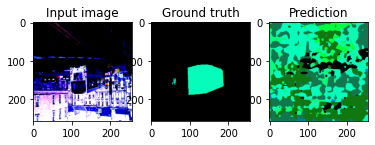

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


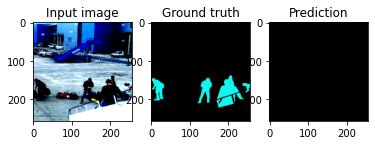

100%|██████████| 186/186 [01:29<00:00,  2.07it/s]


Epoch 0, Running Loss: 0.6637854437523909, Validation Loss: 0.6418846041284582


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


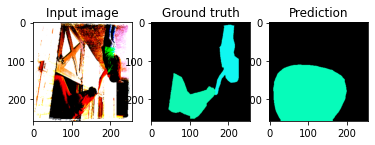

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


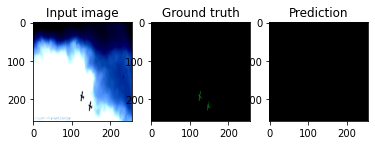

100%|██████████| 186/186 [01:26<00:00,  2.15it/s]


Epoch 1, Running Loss: 0.6397383205071399, Validation Loss: 0.6384633018444943


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


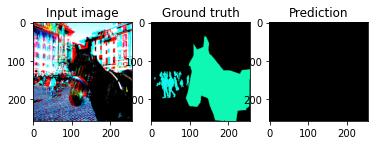

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


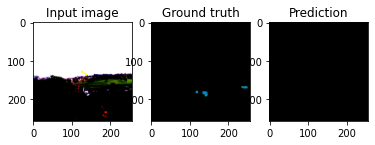

100%|██████████| 186/186 [01:26<00:00,  2.15it/s]


Epoch 2, Running Loss: 0.6382679204636641, Validation Loss: 0.6368302670858239


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


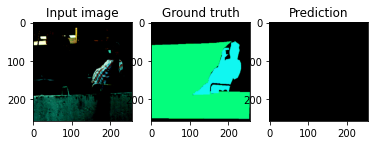

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


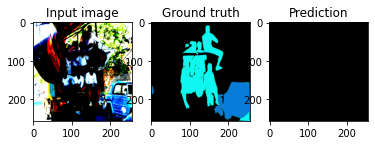

100%|██████████| 186/186 [01:26<00:00,  2.15it/s]


Epoch 3, Running Loss: 0.6382329110132814, Validation Loss: 0.6381176931242789


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


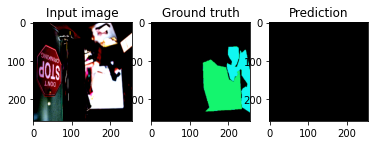

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


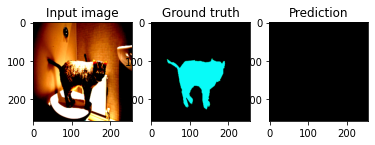

100%|██████████| 186/186 [01:26<00:00,  2.15it/s]


Epoch 4, Running Loss: 0.6382581522925891, Validation Loss: 0.6386517287902934


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


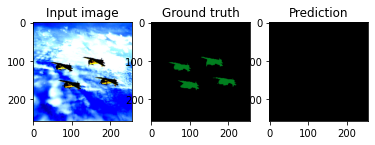

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


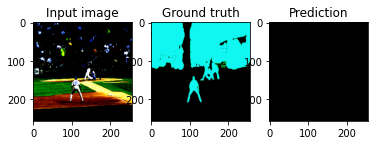

100%|██████████| 186/186 [01:26<00:00,  2.15it/s]


Epoch 5, Running Loss: 0.6382826429335668, Validation Loss: 0.6373001788893053


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


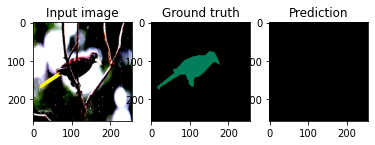

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


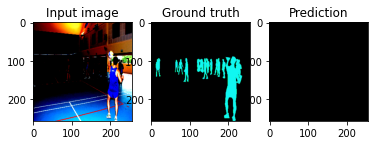

100%|██████████| 186/186 [01:26<00:00,  2.15it/s]


Epoch 6, Running Loss: 0.6382297436886855, Validation Loss: 0.6382091080629697


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


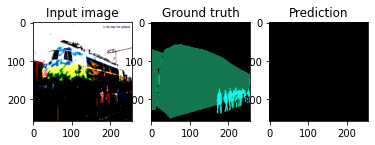

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


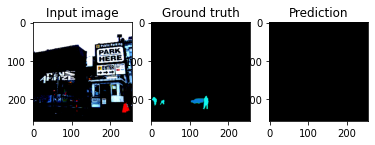

100%|██████████| 186/186 [01:26<00:00,  2.15it/s]


Epoch 7, Running Loss: 0.6382669761102386, Validation Loss: 0.6392371194657459


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


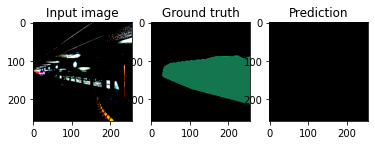

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


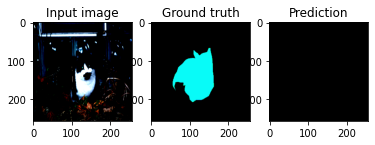

100%|██████████| 186/186 [01:26<00:00,  2.16it/s]


Epoch 8, Running Loss: 0.6382696878762892, Validation Loss: 0.6387041778333725


  0%|          | 0/486 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


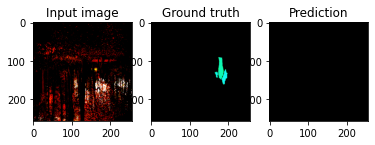

  0%|          | 0/186 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


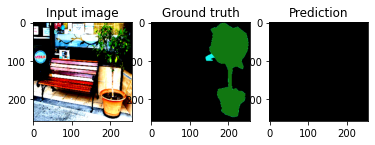

100%|██████████| 186/186 [01:26<00:00,  2.16it/s]

Epoch 9, Running Loss: 0.6382963134918684, Validation Loss: 0.6393007946911679


In [ ]:
EPOCHS = 10
print(epoch)
while epoch < EPOCHS:
  model.train()

  running_loss = 0

  for i, (imgs, labels) in tqdm.tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    imgs = imgs.to(device)
    labels = labels.type(torch.LongTensor).to(device)

    optimizer.zero_grad()
    
    predictions = model(imgs)["out"]

    loss = criterion(predictions, labels)
    running_loss += loss.item()
    loss.backward()
    
    optimizer.step()

    if i == 0:
      show_images(imgs[0], labels[0], predictions[0].argmax(0))

    del loss
    del predictions
    del imgs
    del labels

  running_loss /= len(train_dataloader)
  running_losses.append(running_loss)

  val_loss = validate(model, val_dataloader)
  print(f"Epoch {epoch}, Running Loss: {running_loss}, Validation Loss: {val_loss}")
  epoch += 1

In [ ]:
save_state("fcn_test_scratch_data_augment_dice_loss_10.pth", epoch, model, optimizer, running_losses)